## ei_runner_mp.ipynb 
A version of ei_runner capable of multiprocess simulations using the ei_net class.  
By Sergio Verduzco  
January 2018

In [1]:
# importing libraries
%cd ..
from ei_net import *
from pathos.multiprocessing import ProcessingPool
import sys 

/home/z/projects/draculab


In [2]:
# This is the name of the file where logging will happen
log_file = "./logs/ei_net_mp" + time.strftime("_%m-%d-%y.txt")

In [3]:
%%capture capt 
# logging draculab version used for this session
print('#======================================================')
print('#             | Latest git commit: |')
print('#====================================================== \n#', end=' ')
!git log -1 --oneline --color=never

In [4]:
# Write the output of the cell above in the simulation log
f = open(log_file, mode='a')
f.write(capt.stdout)
f.close()

In [3]:
# Creating input patterns
n_pat = 4  # number of input patterns
pat_arr = np.zeros((4, 25)) # ei_runner.n['x'])) # array with all input patterns

for row in range(5):
    for col in range(5):
        idx = 5*col + row
        if row == col or row+col == 4: # The X input pattern
            pat_arr[0,idx] = 1
        if row == 2 or col == 2:  # The + input pattern
            pat_arr[1,idx] = 1
        if row == 1 or row == 3:  # The = input pattern
            pat_arr[2,idx] = 1
        if col == 1 or col == 3:  # The || input pattern
            pat_arr[3,idx] = 1
pat_arr = pat_arr / 5.

def inp_pat(pres, rows, columns, random=False):
    # The function that creates the input pattern shown at each presentation in ei_net.run
    if random:
        idx = np.random.randint(4)
    else:
        idx = pres % 4
    return pat_arr[idx, :]
#for i in range(6):
#    print(np.reshape(inp_pat(5, 4, 2),(5,5)))

In [4]:
class mp_ei_runner():
    def __init__(self):
        self.name = 'exp_dist_sig_test'
        self.n_procs = 8
        self.n_nets = 8
        self.n_pres = [30]*self.n_nets  # number of presentations for each net
        self.pres_t = [1.]*self.n_nets # duration of presentations for each net
        self.inp_pats = [inp_pat]*self.n_nets # input pattern creator for each net
        self.inp_funcs = [None]*self.n_nets  # input function creator for each net. None sets the default.
        
        
        #F = open("/home/z/projects/draculab/pickles/mp_ei_runner_test0.pkl", 'rb')
        #dill_obj = dill.load(F)
        #self.nets = dill_obj.nets
        
        self.nets = [ei_net(i) for i in range(self.n_nets)] # First run
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_ei_runner object called ' + self.name)
            net.annotate('These tests are to find parameters that work with exp_dist_sig using the new ')
            net.annotate('update method for unit.upd_exp_scale. ')
            #----------------------------------
            net.annotate("Adjusting size of e,i groups.")
            net.set_param('e_geom', 'rows', 16)
            net.set_param('e_geom', 'columns', 16)
            net.set_param('i_geom', 'rows', 8)
            net.set_param('i_geom', 'columns', 8)
            net.annotate("Compensating for the ratio of excitatory to inhibitory units.")
            net.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            net.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            net.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.3, 'high' : -0.01}})
            net.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
            #----------------------------------
            net.annotate("Setting input parameters")
            net.set_param('x_geom', 'rows', 5) 
            net.set_param('x_geom', 'columns', 5) 
            net.set_param('xe_conn', 'weights', {'uniform' : {'low': 0.05, 'high' : 4.}})
            net.set_param('xi_conn', 'weights', {'uniform' : {'low': 0.05, 'high' : 4.}})
            net.set_param('xe_conn', 'mask', {'circular': {'radius': .3}})
            net.set_param('xi_conn', 'mask', {'circular': {'radius': .3}})
            #----------------------------------
            net.annotate("Using Oja input synapses")
            net.set_param('xe_syn', 'type', synapse_types.oja)
            net.set_param('xe_syn', 'lrate', 1./100.)
            net.set_param('xi_syn', 'type', synapse_types.oja)
            net.set_param('xi_syn', 'lrate', 1./100.)
            #----------------------------------
            net.annotate("Using sq_hebb_subsnorm EE synapses")
            net.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            net.set_param('ee_syn', 'lrate', 1./100.)
            net.set_param('ee_syn', 'omega', 2.)
            #----------------------------------
            net.annotate("Using corr_homeo_inhib IE synapses")
            net.set_param('ie_syn', 'type', synapse_types.corr_inh)
            net.set_param('ie_syn', 'lrate', 1./50.)
            net.set_param('e_pars', 'des_act', 0.4)
            #----------------------------------
            net.annotate("Using anti_cov_pre EI synapses")
            net.set_param('ei_syn', 'type', synapse_types.anticov_pre)
            net.set_param('ei_syn', 'lrate', .01)
            #----------------------------------
            net.annotate("Using exp_dist_sig units for the excitatory population.")
            net.set_param('e_pars', 'type', unit_types.exp_dist_sig)
            net.set_param('e_pars', 'tau_scale', 0.01)
            net.set_param('e_pars', 'Kp', 0.05)
            net.set_param('e_pars', 'c', 3.)
            
            net.annotate("Using sigmoidal units for the inhibitory population.")
            net.set_param('i_pars', 'type', unit_types.sigmoidal)
            net.set_param('i_pars', 'tau_scale', 0.01)
            net.set_param('i_pars', 'Kp', 0.05)
            net.set_param('i_pars', 'c', 3.)
            #----------------------------------
            net.set_param('n', 'w_track', 16)
            #----------------------------------
        ## Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        self.nets[n].annotate("Using larger Kp.")
        self.nets[n].set_param('e_pars', 'Kp', .15)
        ### network 2
        n = 2
        self.nets[n].annotate("Using larger tau_scale.")
        self.nets[n].set_param('e_pars', 'tau_scale', 0.1)
        ### network 3
        n = 3
        self.nets[n].annotate("Using larger Kp and tau_scale.")
        self.nets[n].set_param('e_pars', 'tau_scale', 0.1)
        self.nets[n].set_param('e_pars', 'Kp', .15)
        ### Network 4
        n = 4
        self.nets[n].annotate("Using inhibitory exp_dist_sig units.")
        self.nets[n].set_param('i_pars', 'type', unit_types.exp_dist_sig)
        ### Network 5
        n = 5
        self.nets[n].annotate("Using inhibitory exp_dist_sig units and larger Kp.")
        self.nets[n].set_param('i_pars', 'type', unit_types.exp_dist_sig)
        self.nets[n].set_param('e_pars', 'Kp', .15)
        self.nets[n].set_param('i_pars', 'Kp', .15)
        ### Network 6
        n = 6
        self.nets[n].annotate("Using inhibitory exp_dist_sig units and larger tau_scale.")
        self.nets[n].set_param('i_pars', 'type', unit_types.exp_dist_sig)
        self.nets[n].set_param('e_pars', 'tau_scale', .1)
        self.nets[n].set_param('i_pars', 'tau_scale', .1)
        ### Network 7
        n = 7
        self.nets[n].annotate("Using inhibitory exp_dist_sig units and larger Kp, tau_scale.")
        self.nets[n].set_param('i_pars', 'type', unit_types.exp_dist_sig)
        self.nets[n].set_param('e_pars', 'tau_scale', .1)
        self.nets[n].set_param('i_pars', 'tau_scale', .1)
        self.nets[n].set_param('e_pars', 'Kp', .15)
        self.nets[n].set_param('i_pars', 'Kp', .15)
        
        # Building the networks
        for net in self.nets:
            net.build()
        
        
    def run_net(self, net_num):
        print('Running network %d' % (net_num))
        return self.nets[net_num].run(self.n_pres[net_num], self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
    
    
    def run_all(self, save=True, log=False):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        pool = ProcessingPool(nodes=self.n_procs) 
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        self.nets = pool.map(self.run_net, range(self.n_nets))
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        if save:
            for net in self.nets:
                net.history.append('ei_net object being saved in container mp_ei_runner object ' + self.name)
            F = open(self.name+'.pkl', 'wb')
            dill.dump(self, F)
            F.close()
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))

In [5]:
# Simulating
mp_ei_obj = mp_ei_runner()
mp_ei_obj.run_all(save=False, log=False)

Starting 8 processes, 8 networks
Running network 0
Running network 1
Starting presentation 0 at network 1
Running network 2
Starting presentation 0 at network 2
Running network 3
Starting presentation 0 at network 3
Presentation 0 took 64.79551482200623 seconds.
Running network 4
Starting presentation 0 at network 4
Presentation 0 took 65.09782552719116 seconds at network 1.
Starting presentation 1 at network 1
Running network 5
Starting presentation 0 at network 5
Presentation 0 took 67.79984402656555 seconds at network 2.
Starting presentation 1 at network 2
Running network 6
Starting presentation 0 at network 6
Presentation 0 took 65.79826045036316 seconds at network 3.
Starting presentation 1 at network 3
Presentation 1 took 66.00944757461548 seconds.
Running network 7
Starting presentation 0 at network 7
Presentation 1 took 64.55547714233398 seconds at network 1.
Starting presentation 2 at network 1
Presentation 0 took 68.86060619354248 seconds at network 4.
Starting presentation 

Starting presentation 12 at network 1
Presentation 10 took 66.24668335914612 seconds at network 4.
Starting presentation 11 at network 4
Presentation 11 took 58.937479734420776 seconds at network 3.
Starting presentation 12 at network 3
Presentation 12 took 61.98467969894409 seconds at network 2.
Starting presentation 13 at network 2
Presentation 12 took 64.2007405757904 seconds.
Presentation 10 took 60.26530122756958 seconds at network 6.
Starting presentation 11 at network 6
Presentation 10 took 68.47121953964233 seconds at network 5.
Starting presentation 11 at network 5
Presentation 10 took 62.70437502861023 seconds at network 7.
Starting presentation 11 at network 7
Presentation 12 took 65.68426775932312 seconds at network 1.
Starting presentation 13 at network 1
Presentation 11 took 66.03653836250305 seconds at network 4.
Starting presentation 12 at network 4
Presentation 13 took 62.1619770526886 seconds at network 2.
Starting presentation 14 at network 2
Presentation 12 took 73.

Starting presentation 21 at network 7
Presentation 22 took 62.819013595581055 seconds at network 3.
Starting presentation 23 at network 3
Presentation 23 took 61.671016693115234 seconds at network 1.
Starting presentation 24 at network 1
Presentation 20 took 76.0880081653595 seconds at network 5.
Starting presentation 21 at network 5
Presentation 21 took 89.18335008621216 seconds at network 4.
Starting presentation 22 at network 4
Presentation 24 took 80.494145154953 seconds at network 2.
Starting presentation 25 at network 2
Presentation 21 took 89.71024870872498 seconds at network 6.
Starting presentation 22 at network 6
Presentation 24 took 83.81275701522827 seconds.
Presentation 23 took 79.9299464225769 seconds at network 3.
Starting presentation 24 at network 3
Presentation 21 took 94.07908630371094 seconds at network 7.
Starting presentation 22 at network 7
Presentation 24 took 90.86794114112854 seconds at network 1.
Starting presentation 25 at network 1
Presentation 21 took 93.4

# NOTE: This is network 7 in a run of an mp_ei_runner object called exp_dist_sig_test
# NOTE: These tests are to find parameters that work with exp_dist_sig using the new 
# NOTE: update method for unit.upd_exp_scale. 
# NOTE: Adjusting size of e,i groups.
# NOTE: Compensating for the ratio of excitatory to inhibitory units.
# NOTE: Setting input parameters
# NOTE: Using Oja input synapses
# NOTE: Using sq_hebb_subsnorm EE synapses
# NOTE: Using corr_homeo_inhib IE synapses
# NOTE: Using anti_cov_pre EI synapses
# NOTE: Using exp_dist_sig units for the excitatory population.
# NOTE: Using sigmoidal units for the inhibitory population.
# NOTE: Using inhibitory exp_dist_sig units and larger Kp, tau_scale.



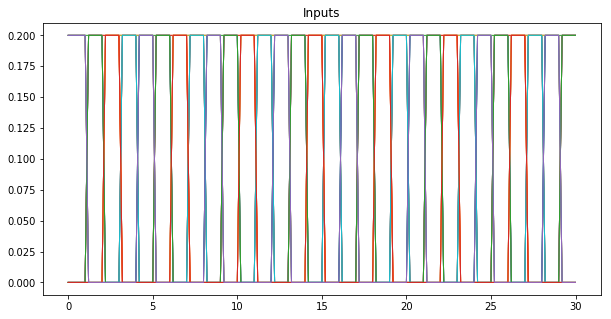

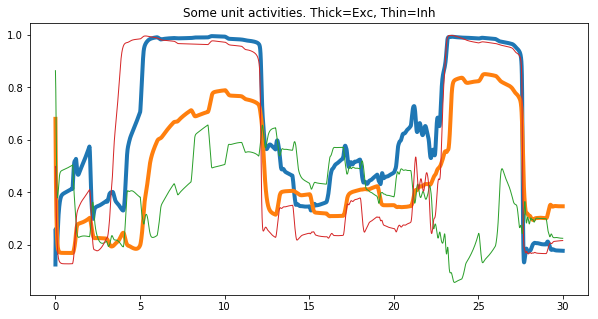

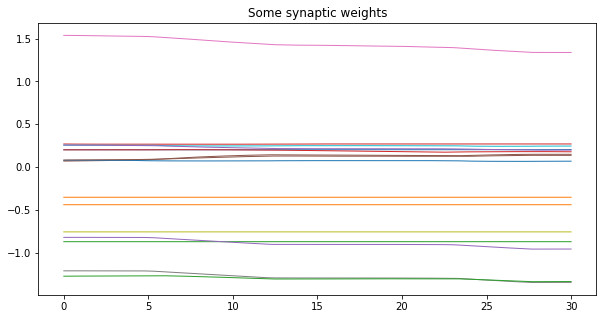

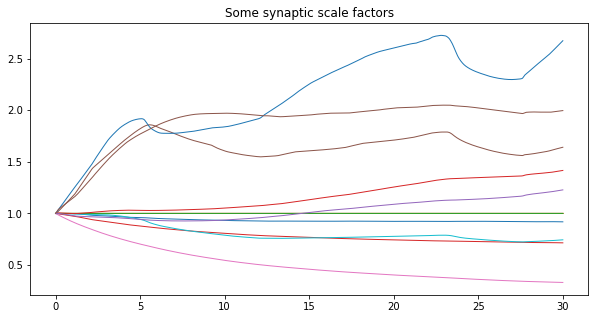

In [23]:
# basic plot 
%matplotlib inline
net_num = 7
ei_runner = mp_ei_obj.nets[net_num]
print(ei_runner.notes)
ei_runner.basic_plot()

In [24]:
ei_runner.double_anim(ei_runner.e, slider=False, interv=20, nbins=20, thr=0.7, pdf=True)

In [ ]:
# Plot the highest excitatory unit activities
%matplotlib inline
n_top = 5  # how many units to plot
top_pop = np.array(ei_runner.e)  # population to visualize
top_units = ei_runner.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = ei_runner.all_activs[top_pop[top_units]].transpose()
plt.plot(ei_runner.all_times, top_acts)
plt.show()

[ 55  29 141 194   1 240 123]


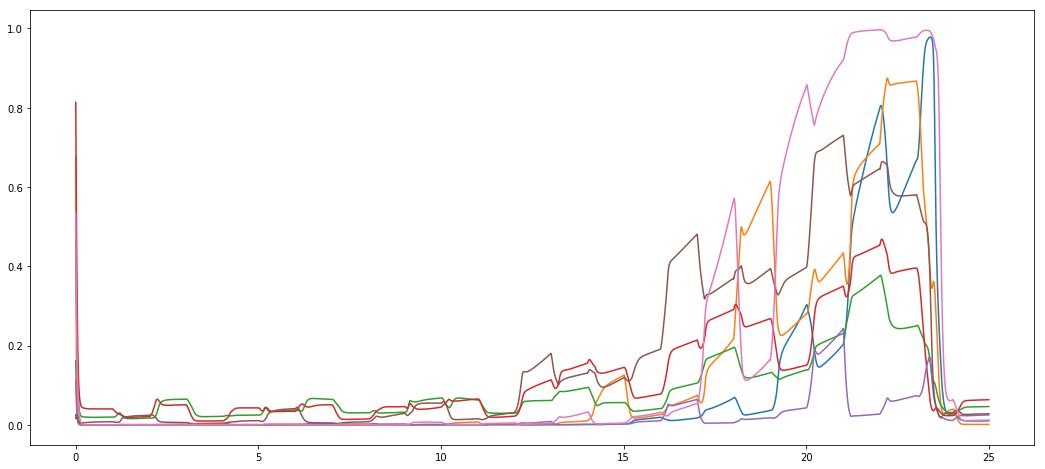

In [13]:
# Plot the lowest excitatory unit activities
n_bottom = 8  # how many units to plot plus one
bottom_pop = np.array(ei_runner.e)  # population to visualize
bottom_units = ei_runner.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = ei_runner.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(ei_runner.all_times, bottom_acts)
plt.show()

In [41]:
# Annotations for individual networks
ei_runner.annotate('Started well, everyone got active after around 5 presentations, went into a period ', make_history=False)
ei_runner.annotate('where not everyone was active after 12 or so seconds, and lost it again  ', make_history=False)
ei_runner.annotate('in the twenty-something presentation. ', make_history=False)
#ei_runner.annotate(' ', make_history=False)


In [42]:
# log all annotations
mp_ei_obj.log()

In [ ]:
ei_runner.history

In [ ]:
ei_runner.conn_anim(ei_runner.x, ei_runner.e, slider=True, weights=True)

In [ ]:
ei_runner.act_anim(ei_runner.e, 0.9, interv=20, slider=True)

In [ ]:
ei_runner.hist_anim(ei_runner.e, slider=True, nbins=20, pdf=True)

In [49]:
# saving
for net in mp_ei_obj.nets:
    net.history.append('ei_net object being saved in container mp_ei_runner object ' + mp_ei_obj.name)
F = open(mp_ei_obj.name+'.pkl', 'wb')
dill.dump(mp_ei_obj, F)
F.close()

In [2]:
# loading
F = open("/media/z/DATA/pickles/ssrdc_test1_ei_runner_mp.pkl", 'rb')
mp_ei_obj = dill.load(F)

In [ ]:
# Simulating a single network
n_pres = 8
pres_time = 1.
ei_runner.run(n_pres, pres_time, set_inp_pat=inp_pat)